In [1]:
from exp.nb_Tesis import *

In [5]:
min_dim = 352 # 448

trainImagesFolderName = f'small_{min_dim}_ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [6]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [8]:
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [10]:
max_of_each = 70
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [12]:
torch.cuda.set_device(1)

## Load the dataset

In [13]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=.3,p_affine=1, max_warp=0)

data = ImageList.from_folder(destFolder)\
.split_by_rand_pct()\
.label_from_func(get_label_for_image_path)\
.transform(tfms,size=352)\
.databunch(bs=16)\
.normalize()

In [ ]:
data.show_batch(5)

In [14]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 BKL     671
MEL     663
BCC     657
AK      651
NV      648
SCC     504
VASC    211
DF      188
dtype: int64 

 valid_count: 
 NV      180
BCC     171
MEL     165
AK      158
BKL     157
SCC     124
DF       51
VASC     42
dtype: int64
ratios:
AK      0.242704
BCC     0.260274
BKL     0.233979
DF      0.271277
MEL     0.248869
NV      0.277778
SCC     0.246032
VASC    0.199052
dtype: float64 %


In [18]:
def get_class_weights():
    weighted_classes = [{c: max(train_count) / train_count[c]} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ] 
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-4, balanced=True):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights())
    random_seed(7,True)
    max_lr = slice(1e-3,1e-2)
    wd = lr / 10
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd, callbacks = [
        SaveModelCallback(learn=learner,name=log_name),
        CSVLogger(learn=learner,filename=log_name)
    #     ReduceLROnPlateauCallback(learn=learn)
    ])

# Experiment: DenseNet201 vs EfficientNet-b0 vs EfficientNet-b3

First let's see the difference between efficientnet and densenet201 all things being equal

## Efficientnet-b0

In [46]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 129, 129]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ZeroPad2d            [32, 66, 66]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 64, 64]         0          False     
_________________________________________________

[{'AK': 1.0}, {'BCC': 1.0106382978723405}, {'BKL': 1.0477941176470589}, {'DF': 1.5159574468085106}, {'MEL': 1.0035211267605635}, {'NV': 1.0634328358208955}, {'SCC': 1.0070671378091873}, {'VASC': 1.4108910891089108}]
[1.0, 1.0106382978723405, 1.0477941176470589, 1.5159574468085106, 1.0035211267605635, 1.0634328358208955, 1.0070671378091873, 1.4108910891089108]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.818445,1.718047,0.666667,0.333333,0.519091,00:18
1,1.539726,1.471600,0.577519,0.422481,0.581077,00:17
2,1.435312,1.440250,0.525194,0.474806,0.400875,00:17
3,1.302367,1.417880,0.500000,0.500000,0.524613,00:18
4,1.143010,1.257084,0.432171,0.567829,0.630471,00:17
5,0.984225,1.149337,0.403101,0.596899,0.537811,00:17
6,0.814959,1.109193,0.377907,0.622093,0.529764,00:17
7,0.768689,1.076705,0.372093,0.627907,0.536397,00:18


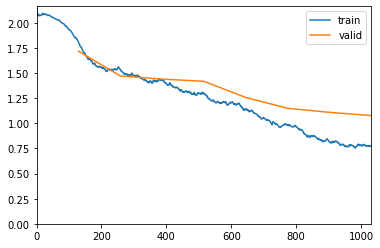

Better model found at epoch 0 with valid_loss value: 1.7180471420288086.
Better model found at epoch 1 with valid_loss value: 1.471599817276001.
Better model found at epoch 2 with valid_loss value: 1.4402501583099365.
Better model found at epoch 3 with valid_loss value: 1.4178804159164429.
Better model found at epoch 4 with valid_loss value: 1.2570843696594238.
Better model found at epoch 5 with valid_loss value: 1.149336814880371.
Better model found at epoch 6 with valid_loss value: 1.1091934442520142.
Better model found at epoch 7 with valid_loss value: 1.0767048597335815.


In [48]:
train_learner(learn_b0,'EfficientNet-b0')

## Densenet

In [50]:
dense_learn = cnn_learner(data,models.densenet201, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

dense_learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [128, 32, 32]        8,192      False     
___________________________________________________

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.665530,1.947946,0.598837,0.401163,0.527677,00:45
1,2.229905,1.877940,0.571705,0.428295,0.527677,00:46
2,1.916193,1.491648,0.527132,0.472868,0.536229,00:45
3,1.673306,1.731876,0.529070,0.470930,0.537912,00:45
4,1.487908,1.459155,0.472868,0.527132,0.519562,00:44
5,1.314788,1.266923,0.441860,0.558140,0.474646,00:45
6,1.131491,1.233500,0.439922,0.560078,0.470640,00:46
7,1.058309,1.215065,0.436047,0.563953,0.457845,00:46


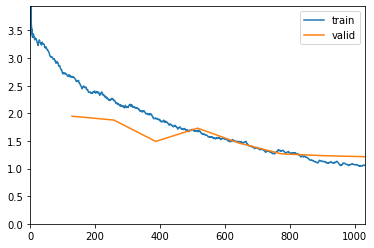

Better model found at epoch 0 with valid_loss value: 1.9479464292526245.
Better model found at epoch 1 with valid_loss value: 1.8779397010803223.
Better model found at epoch 2 with valid_loss value: 1.4916479587554932.
Better model found at epoch 4 with valid_loss value: 1.4591550827026367.
Better model found at epoch 5 with valid_loss value: 1.2669233083724976.
Better model found at epoch 6 with valid_loss value: 1.2335002422332764.
Better model found at epoch 7 with valid_loss value: 1.2150650024414062.


In [26]:
train_learner(dense_learn,'DenseNet-201')

## EfficientNet-b3

In [31]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'
model_b3 = EfficientNet.from_pretrained(model_name)
model_b3._fc = nn.Linear(1536, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b3 = Learner(data,model_b3, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b3.summary()

Loaded pretrained weights for efficientnet-b3


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 129, 129]        0          False     
______________________________________________________________________
BatchNorm2d          [40, 64, 64]         80         True      
______________________________________________________________________
ZeroPad2d            [40, 66, 66]         0          False     
______________________________________________________________________
BatchNorm2d          [40, 64, 64]         80         True      
______________________________________________________________________
Identity             [40, 1, 1]           0          False     
______________________________________________________________________
Identity             [10, 1, 1]           0          False     
______________________________________________________________________
Identity             [40, 64, 64]         0          False     
_________________________________________________

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.840573,1.688768,0.641473,0.358527,0.533232,00:26
1,1.615813,1.886212,0.625969,0.374031,0.548586,00:28
2,1.536669,1.661582,0.600775,0.399225,0.435488,00:28
3,1.436897,1.913213,0.548450,0.451550,0.557508,00:27
4,1.256224,1.445672,0.461240,0.538760,0.451010,00:27
5,1.118578,1.271640,0.451550,0.548450,0.390673,00:26
6,0.916247,1.187197,0.406977,0.593023,0.518350,00:27
7,0.843419,1.153786,0.405039,0.594961,0.503434,00:27


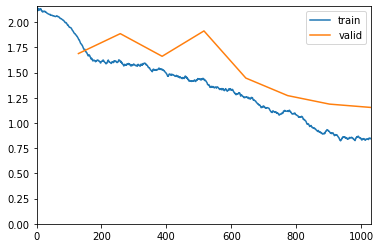

Better model found at epoch 0 with valid_loss value: 1.6887680292129517.
Better model found at epoch 2 with valid_loss value: 1.6615818738937378.
Better model found at epoch 4 with valid_loss value: 1.4456721544265747.
Better model found at epoch 5 with valid_loss value: 1.2716400623321533.
Better model found at epoch 6 with valid_loss value: 1.187197208404541.
Better model found at epoch 7 with valid_loss value: 1.1537859439849854.


In [32]:
train_learner(learn_b3,'EfficientNet-b3')

# Conclusion

* It seems that densenet201 performs worse (higher valid loss) than efficientnet-b0 on 128 sized images.
* Not only it trains slower, but it achieves worse performance. 
* Moreso, EfficientNet-b3 also seems to perform worse than efficientNet-b0. This is counterintuitive and may be due to image size or number of training epochs

# Experiment: Balance or not class weights on EfficientNet-b0

Let's try balancing them

In [45]:
def plot_conf_matrix(interpretation):
    interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)
    print("Balanced accuracy: ", get_balanced_accurracy(interpretation))
    plt.tight_layout()

def get_balanced_accurracy(interpretation):
    matrix = interpretation.confusion_matrix()
    balanced_acc = 0
    for i in range(len(matrix[0])):
        row = matrix[i]
        correctGuesses = row[i]
        allPossibleTries = row.sum()
        classAcurracy = correctGuesses / allPossibleTries
        balanced_acc += classAcurracy
    balanced_acc /= len(matrix[0])
    return balanced_acc



### Balanced Efficientnet-b0

In [50]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 353, 353]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 178, 178]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 176, 176]       0          False     
_________________________________________________

[{'AK': 1.0307219662058371}, {'BCC': 1.02130898021309}, {'BKL': 1.0}, {'DF': 3.5691489361702127}, {'MEL': 1.0120663650075414}, {'NV': 1.0354938271604939}, {'SCC': 1.3313492063492063}, {'VASC': 3.1800947867298577}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.505175,1.806959,0.669847,0.330153,0.679216,01:11
1,1.332565,1.633146,0.562977,0.437023,0.339568,01:11
2,1.007191,0.949778,0.383588,0.616412,0.578001,01:10
3,0.910987,0.876572,0.364504,0.635496,0.580454,01:10


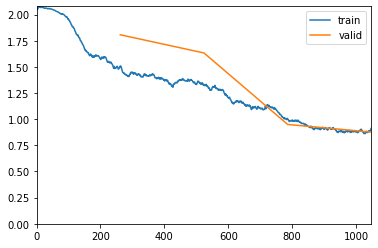

Better model found at epoch 0 with valid_loss value: 1.8069586753845215.
Better model found at epoch 1 with valid_loss value: 1.633145809173584.
Better model found at epoch 2 with valid_loss value: 0.9497779011726379.
Better model found at epoch 3 with valid_loss value: 0.8765718936920166.


In [51]:
train_learner(learn_b0, 'EfficientNet-b0', epochs=4, lr=1e-3)

In [54]:
interp = ClassificationInterpretation.from_learner(learn_b0)

Balanced accuracy:  0.6686269165331498


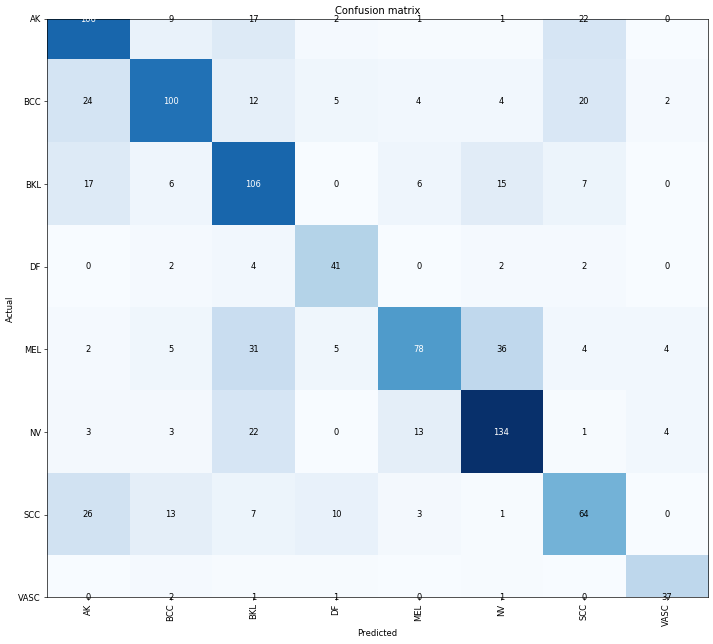

In [55]:
plot_conf_matrix(interp)
plt.tight_layout()

### Unbalanced efficientnet-b0

In [21]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 353, 353]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 178, 178]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 176, 176]       0          False     
_________________________________________________

Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.496898,1.590010,0.577290,0.422710,0.720372,01:10
1,1.325589,1.221184,0.452290,0.547710,0.491775,01:10
2,1.043244,0.970932,0.360687,0.639313,0.546427,01:10
3,0.929495,0.900435,0.327290,0.672710,0.597125,01:10


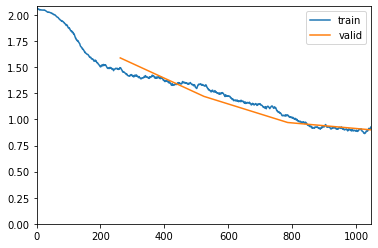

Better model found at epoch 0 with valid_loss value: 1.5900102853775024.
Better model found at epoch 1 with valid_loss value: 1.2211841344833374.
Better model found at epoch 2 with valid_loss value: 0.9709323048591614.
Better model found at epoch 3 with valid_loss value: 0.9004346132278442.


In [22]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=4, lr=1e-3, balanced=False)

In [48]:
interp_unb = ClassificationInterpretation.from_learner(learn_b0_unb)

Balanced accuracy:  0.6913385395384611


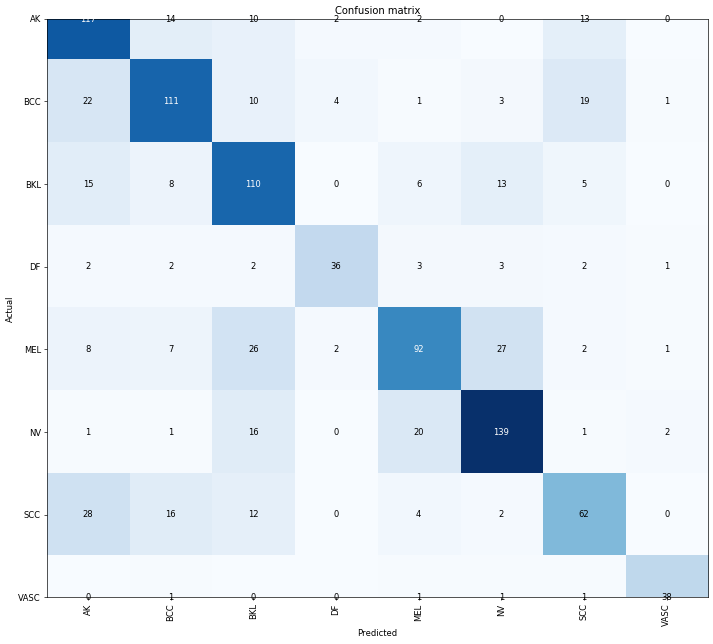

In [49]:
plot_conf_matrix(interp_unb)
plt.tight_layout()

# Conclusion

* Para estas corridas, no balancear por clase parece arrojar la mayor balanced accuracy. Habrá que probar si esto es consistente con corridas con mayor cantidad de epocas. 
* Sin embargo, se puede notar como al balancear por clase aumente la accuracy de la clase DF que es la que se encuentra presente en menor medida en el set de entrenamiento

# Other

# Test

In [ ]:
learn.export('2018_new.pkl')

In [ ]:
learn2 = load_learner(path=trainImagesFolderName, file="2018_new.pkl", 
                     test=ImageList.from_folder(smallTestImagesFolderName),
                     )

In [ ]:
preds, y = learn2.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

In [ ]:
arrOfPreds = [learn2.data.classes[pred.argmax().item()] for pred in preds];arrOfPreds[0:5]

In [ ]:

allCategories = learn2.data.classes
cols = ['image'] + allCategories


predictions = []
for idx, filePath in enumerate(learn2.data.test_ds.items):
  row = {}
  current_pred = preds[idx]
  max_confidence = current_pred.max().item()
  row['image'] = filePath.name.replace('.jpg','')
  for idx2, cat in enumerate(allCategories):
    row[cat] = current_pred[idx2].item()
  
  predictions.append(row)

predictionsDf = pd.DataFrame(predictions, columns=cols);
  
  

In [ ]:
len(predictionsDf)
predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
predictionsDf2 = predictionsDf.drop(columns=['SCC'])
predictionsDf2.head()

In [ ]:
predictions_csv_path = 'predictionsTest2019.csv'
predictionsDf2.to_csv(predictions_csv_path, index=False)